In [1]:
%load_ext autoreload
%autoreload complete
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from tqdm.notebook import tqdm

from protest_impact.util import cache, project_root

## Unsupervised

In [8]:
from protest_impact.data.news.config import region_tags

ignore = [
    "germany_national",
    "germany_regional",
    "baden-württemberg",
    "mecklenburg-vorpommern",
]
regions = sorted(set(region_tags) - set(ignore))

In [7]:
from os import environ
from pprint import pprint

from dotenv import load_dotenv

from protest_impact.util import get_cached

load_dotenv()


def get_general_word_counts(region, start_date, end_date, num_words, sample_size):
    response = get_cached(
        "https://api.mediacloud.org/api/v2/wc/list/",
        params={
            "q": f"tags_id_media:{region_tags[region]}",
            "fq": f"publish_date:[{start_date}T00:00:00Z TO {end_date}T00:00:00Z]",
            "num_words": num_words,
            "sample_size": sample_size,
            "key": environ["MEDIACLOUD_API_KEY"],
        },
        headers={"Accept": "application/json"},
    )
    return response.json()

In [38]:
from time import time

data = []
for num_words in tqdm(range(10, 16)):
    num_words = int(np.exp2(num_words))
    for sample_size in tqdm(range(14, 18)):
        sample_size = int(np.exp2(sample_size))
        for region in ["nordrhein-westfalen"]:
            start = time()
            results = get_general_word_counts(
                region, "2021-06-06", "2021-06-07", num_words, sample_size
            )
            end = time()
            data.append(
                {
                    "num_words": num_words,
                    "sample_size": sample_size,
                    "time": end - start,
                    "results": results,
                }
            )

df = pd.DataFrame(data)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

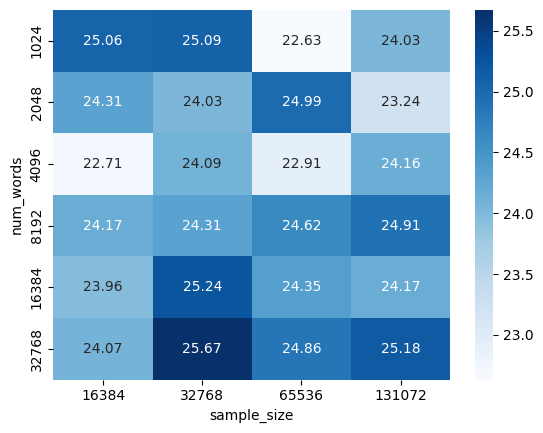

In [39]:
# plot heatmap of time depending on num_words and sample_size
heatmap_df = df.pivot(index="num_words", columns="sample_size", values="time")
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Blues")
plt.show()

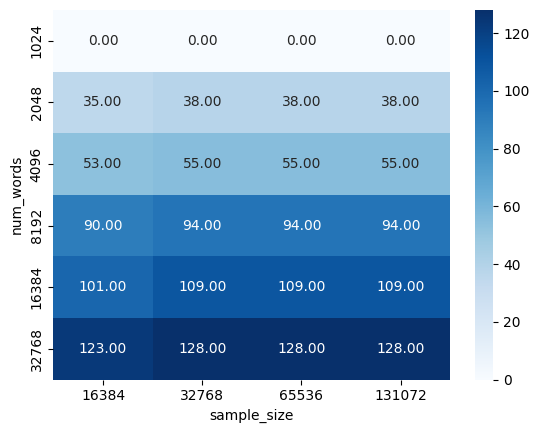

In [40]:
df["climate_count"] = df["results"].apply(
    lambda x: sum([a["count"] for a in x if "klima" in a["stem"]])
)

# plot heatmap of climate_count depending on num_words and sample_size
heatmap_df = df.pivot(index="num_words", columns="sample_size", values="climate_count")
sns.heatmap(heatmap_df, annot=True, fmt=".2f", cmap="Blues")
plt.show()

In [41]:
df["results"].iloc[0]

[{'count': 3210, 'stem': 'ef', 'term': 'efs'},
 {'count': 3012, 'stem': 'ejf', 'term': 'ejf'},
 {'count': 2536, 'stem': 'voe', 'term': 'voe'},
 {'count': 2456, 'stem': 'dmbttµ', 'term': 'dmbttµ'},
 {'count': 2099, 'stem': 'jo', 'term': 'jo'},
 {'count': 1459, 'stem': 'ejw', 'term': 'ejw'},
 {'count': 1334, 'stem': '00xxx', 'term': '00xxx'},
 {'count': 1318, 'stem': 'ebt', 'term': 'ebt'},
 {'count': 1311, 'stem': '00jnh', 'term': '00jnh'},
 {'count': 1305, 'stem': 'efo', 'term': 'efo'},
 {'count': 1117, 'stem': 'kqh', 'term': 'kqh'},
 {'count': 1055, 'stem': 'tsdtfuµ', 'term': 'tsdtfuµ'},
 {'count': 1004, 'stem': 'jn', 'term': 'jn'},
 {'count': 951, 'stem': 'ujumfµ', 'term': 'ujumfµ'},
 {'count': 946, 'stem': '²', 'term': '²'},
 {'count': 938, 'stem': 'bvg', 'term': 'bvg'},
 {'count': 929, 'stem': 'tpvsdf', 'term': 'tpvsdf'},
 {'count': 926, 'stem': 'nju', 'term': 'nju'},
 {'count': 926, 'stem': 'gýs', 'term': 'gýs'},
 {'count': 908, 'stem': 'jtu', 'term': 'jtu'},
 {'count': 887, 'stem'

In [42]:
# List of common German words
common_german_words = [
    "und",
    "die",
    "das",
    "der",
    "in",
    "ist",
    "zu",
    "für",
    "mit",
    "auf",
]

# List of extracted words from the text
extracted_words = [
    "ef",
    "ejf",
    "voe",
    "dmbttµ",
    "jo",
    "ejw",
    "00xxx",
    "ebt",
    "00jnh",
    "efo",
    "kqh",
    "tsdtfuµ",
    "jn",
    "ujumfµ",
    "²",
    "bvg",
    "tpvsdf",
    "nju",
    "gýs",
    "jtu",
    "fjof",
    "bvdi",
    "xq",
    "ft",
    "wpo",
    "isfgµ",
    "nfejb",
    "os",
    "tjdi",
    "ebub",
]


# Function to encode and decode words
def encode_decode(word, encode="utf-8", decode="ISO-8859-1"):
    encoded_word = word.encode(encode)
    decoded_word = encoded_word.decode(decode)
    return decoded_word


# Check if encoding errors match the extracted words
for word in common_german_words:
    transformed_word = encode_decode(word)
    if transformed_word in extracted_words:
        print(f"Original word: {word}, Transformed word: {transformed_word}")

## Confounders

That is, data on climate or all events or everything.

Nexis (2020-2022):

- DPA
  - DPA AFX: 573k
  - DPA RegioLine: 367k
- Klima
  - DPA AFX: 23k (30)
  - DPA RegioLine: 10k (12)
- Rassismus
  - DPA AFX: 8k
  - DPA RegioLine: 5k
- Tierschutz
  - DPA AFX: 3k
  - DPA RegioLine: 3k

## Full texts for coding

- Dereko Klima: ca 500k (gesamtes Korpus, all time)
- racism: 68k (2020-22)
- animals: 30k